In [2]:
import zipfile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

zip_path="../../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/cleaned/data_cleaned.zip"
def read_file(zip_path,filename):
    with zipfile.ZipFile(zip_path,"r") as z :
        with z.open(filename,'r') as f :
            return pd.read_csv(f)
train_df=read_file(zip_path,"train.csv")

In [3]:
train_time= train_df[['index','timestamp']].copy()

In [4]:
train_time.head(5)

,index,timestamp
0,0,1995-07-01 00:00:01
1,1,1995-07-01 00:00:06
2,2,1995-07-01 00:00:09
3,3,1995-07-01 00:00:11
4,4,1995-07-01 00:00:11


In [5]:
train_time["timestamp"].astype(str).head(5)

0    1995-07-01 00:00:01
1    1995-07-01 00:00:06
2    1995-07-01 00:00:09
3    1995-07-01 00:00:11
4    1995-07-01 00:00:11
Name: timestamp, dtype: str

In [6]:
def add_time_features(df):
    """
    Clean and enrich parsed logs with datetime and features.
    """
    # Parse datetime
    df["timestamp"] = pd.to_datetime(
        df["timestamp"],
        format="%Y-%m-%d %H:%M:%S",
        errors="coerce"
    )

    # Time features
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["weekday"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month

    df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)


    return df
train_time=add_time_features(train_time)


In [7]:
train_time.tail(5)

,index,timestamp,hour,day,weekday,month,is_weekend
2934925,2934925,1995-08-22 23:59:55,23,22,1,8,0
2934926,2934926,1995-08-22 23:59:57,23,22,1,8,0
2934927,2934927,1995-08-22 23:59:57,23,22,1,8,0
2934928,2934928,1995-08-22 23:59:58,23,22,1,8,0
2934929,2934929,1995-08-22 23:59:59,23,22,1,8,0


In [8]:
display(train_time[train_time["timestamp"].between("1995-08-02", "1995-08-04")].head())
display(train_time[train_time["timestamp"].between("1995-08-02", "1995-08-04")].tail())

,index,timestamp,hour,day,weekday,month,is_weekend
1925694,1925694,1995-08-03 04:36:13,4,3,3,8,0
1925695,1925695,1995-08-03 04:36:16,4,3,3,8,0
1925696,1925696,1995-08-03 04:36:18,4,3,3,8,0
1925697,1925697,1995-08-03 04:36:18,4,3,3,8,0
1925698,1925698,1995-08-03 04:36:19,4,3,3,8,0


,index,timestamp,hour,day,weekday,month,is_weekend
1967077,1967077,1995-08-03 23:59:50,23,3,3,8,0
1967078,1967078,1995-08-03 23:59:51,23,3,3,8,0
1967079,1967079,1995-08-03 23:59:53,23,3,3,8,0
1967080,1967080,1995-08-03 23:59:59,23,3,3,8,0
1967081,1967081,1995-08-04 00:00:00,0,4,4,8,0


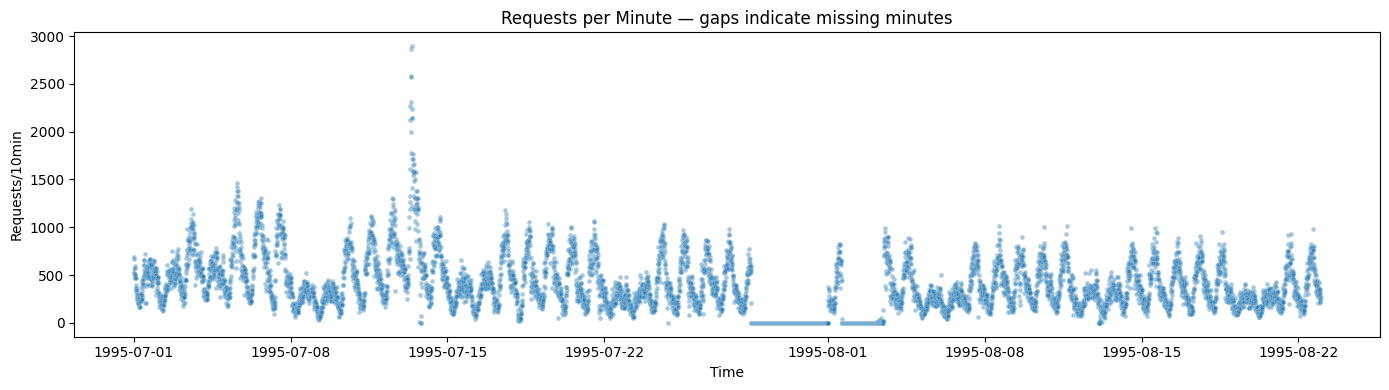

In [9]:
s10m = (
    train_time.assign(timestamp=pd.to_datetime(train_time["timestamp"]))
      .set_index("timestamp")
      .resample("10min")
      .size()
      .rename("requests")
      .asfreq("10min")
      .reset_index()
)

# Vẽ scatter chỉ các phút có dữ liệu
s10m_nonnull = s10m.dropna()

plt.figure(figsize=(14,4))
sns.scatterplot(
    data=s10m_nonnull,
    x="timestamp",
    y="requests",
    s=12,
    alpha=0.4
)
plt.title("Requests per Minute — gaps indicate missing minutes")
plt.xlabel("Time")
plt.ylabel("Requests/10min")
plt.tight_layout()
plt.show()

In [10]:
display(train_df[train_df["timestamp"].between("1995-07-28", "1995-07-31")].tail())

,index,host,timestamp,request,response,bytes
1891693,1891693,163.205.53.14,1995-07-28 13:32:22,GET /shuttle/technology/images/srb_mod_compare...,200,28219.0
1891694,1891694,163.205.53.14,1995-07-28 13:32:23,GET /images/KSC-logosmall.gif HTTP/1.0,200,1204.0
1891695,1891695,tiger2.ocs.lsu.edu,1995-07-28 13:32:23,GET /shuttle/missions/missions.html HTTP/1.0,200,8677.0
1891696,1891696,199.0.2.27,1995-07-28 13:32:23,GET /images/ksclogo-medium.gif HTTP/1.0,200,5866.0
1891697,1891697,tornado.umd.edu,1995-07-28 13:32:25,GET /shuttle/missions/sts-74/sts-74-patch-smal...,200,5494.0


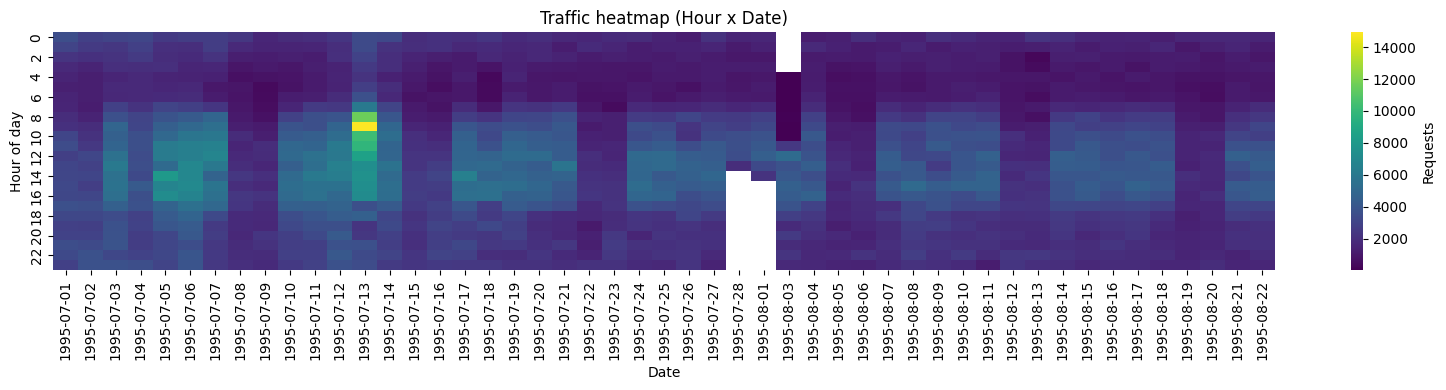

In [11]:
h = (train_time
     .assign(date=train_time["timestamp"].dt.date,
             hour=train_time["timestamp"].dt.hour)
     .groupby(["date","hour"])
     .size()
     .rename("req")
     .reset_index()
)

pivot = h.pivot(index="hour", columns="date", values="req")

plt.figure(figsize=(16,4))
sns.heatmap(pivot,cmap='viridis', cbar_kws={"label":"Requests"})
plt.title("Traffic heatmap (Hour x Date)")
plt.xlabel("Date")
plt.ylabel("Hour of day")
plt.tight_layout()
plt.show()

In [12]:
train_time.to_parquet(
    "../../features/04_timestamp_train.parquet",
    engine="fastparquet",  
    index=False
)